In [13]:
import torch
import os, pickle
import numpy as np
import evaluate
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
from torchinfo import summary
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch import nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm

In [14]:
base_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")

config = base_model.config
config.num_channels = 18
config.num_labels = 2
model = SegformerForSemanticSegmentation(config)

# Added batch size to input_size
summary(model, input_size=(1, 18, 128, 128))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                                      Output Shape              Param #
SegformerForSemanticSegmentation                                            [1, 2, 32, 32]            --
├─SegformerModel: 1-1                                                       [1, 32, 32, 32]           --
│    └─SegformerEncoder: 2-1                                                [1, 32, 32, 32]           --
│    │    └─ModuleList: 3-10                                                --                        (recursive)
│    │    └─ModuleList: 3-11                                                --                        (recursive)
│    │    └─ModuleList: 3-12                                                --                        (recursive)
│    │    └─ModuleList: 3-10                                                --                        (recursive)
│    │    └─ModuleList: 3-11                                                --                        (recursive)
│    

In [15]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(18, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
 

In [16]:
test_input  = torch.randn(1, 18, 128, 128)

output = model(test_input)

print(output.logits.shape)

torch.Size([1, 2, 32, 32])


In [17]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset

def get_indices(arr):
    if arr.ndim != 3 or arr.shape[2] < 7:
        raise ValueError("Input array must be 3-dimensional with at least 7 channels.")
    
    bands = {
        "ndvi": (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + arr[:, :, 3] + 1e-7),
        "evi": 2.5 * (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + 6 * arr[:, :, 3] - 7.5 * arr[:, :, 1] + 1),
        "savi": 1.5 * (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + arr[:, :, 3] + 0.5),
        "msavi": 0.5 * (2 * arr[:, :, 4] + 1 - np.sqrt((2 * arr[:, :, 4] + 1) ** 2 - 8 * (arr[:, :, 4] - arr[:, :, 3]))),
        "ndmi": (arr[:, :, 4] - arr[:, :, 5]) / (arr[:, :, 4] + arr[:, :, 5] + 1e-7),
        "nbr": (arr[:, :, 4] - arr[:, :, 6]) / (arr[:, :, 4] + arr[:, :, 6] + 1e-7),
        "nbr2": (arr[:, :, 5] - arr[:, :, 6]) / (arr[:, :, 5] + arr[:, :, 6] + 1e-7),
    }
    for name in bands:
        value = np.nan_to_num(bands[name])
        arr = np.dstack((arr, value))
    return arr

class SlidingWindowDataset(Dataset):
    def __init__(self, pickle_dir, window_size=128, stride=64, reduce_indices=False):
        self.pickle_dir = pickle_dir
        self.window_size = window_size
        self.stride = stride
        self.reduce_indices = reduce_indices
        self.processed_images, self.processed_masks = self._process_data()

    def _process_data(self):
        processed_images = []
        processed_masks = []
        
        for file_name in os.listdir(self.pickle_dir):
            if file_name.endswith('.pkl'):
                with open(os.path.join(self.pickle_dir, file_name), 'rb') as f:
                    img, mask = pickle.load(f, encoding='latin1')
                
                if img.ndim == 3 and img.shape[2] >= 7:
                    img = get_indices(img)
                    h, w, _ = img.shape
                    for i in range(0, h - self.window_size + 1, self.stride):
                        for j in range(0, w - self.window_size + 1, self.stride):
                            window_img = img[i:i + self.window_size, j:j + self.window_size]
                            window_mask = mask[i:i + self.window_size, j:j + self.window_size]
                            class_0_ratio = np.sum(window_mask == 0) / window_mask.size
                            class_1_ratio = np.sum(window_mask == 1) / window_mask.size
                            class_2_ratio = np.sum(window_mask == 2) / window_mask.size
                            if 0.3 <= class_1_ratio <= 0.7 and 0.3 <= class_2_ratio <= 0.7 and class_0_ratio < 0.5:
                                processed_images.append(window_img)
                                processed_masks.append(window_mask)
                else:
                    print(f"Skipping image with shape {img.shape} in file {file_name}")
        
        return processed_images, processed_masks

    def __len__(self):
        return len(self.processed_images)

    def __getitem__(self, idx):
        image = self.processed_images[idx]
        mask = self.processed_masks[idx]
        
        if mask.dtype == np.uint16:
            mask = mask.astype(np.int64)
            
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.reduce_indices:
            mask = mask - 1
            mask[mask == -1] = 255

        encoded_data = {
            'pixel_values': image,
            'labels': mask
        }

        return encoded_data

# Example usage:
# dataset = SlidingWindowDataset('path_to_pickle_directory')
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
root_dir = 'data/train/training_2015_pickled_data'

dataset = SlidingWindowDataset(pickle_dir=root_dir, window_size=128, reduce_indices=True)

SEED = 123
LEARNING_RATE = 1e-5
BATCH_SIZE = 16
TRAIN_DEV_TEST_SPLIT = (0.8, 0.1, 0.1)

generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = random_split(dataset, TRAIN_DEV_TEST_SPLIT, generator)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [19]:
batch = next(iter(train_dataloader))

In [20]:
# Take a mask and check if it has any values other than 0 and 1
mask = batch['labels']
image = batch['pixel_values']

print(torch.unique(mask))
print(mask.shape)
print(image.shape)

tensor([  0,   1, 255])
torch.Size([16, 128, 128])
torch.Size([16, 18, 128, 128])


In [21]:
# Take a mask and check if it has any values other than 0 and 1
mask = batch['labels']

print(torch.unique(mask))

tensor([  0,   1, 255])


In [22]:
print(len(dataset))

#3321

692


In [24]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the metric functions
def compute_accuracy_ignore_background(preds, labels, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    accuracy = (preds == labels).mean()
    return accuracy

def compute_miou_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    ious = []
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def compute_precision_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    precision_per_class = precision_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': precision for i, precision in enumerate(precision_per_class) if i != ignore_index}

def compute_recall_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    recall_per_class = recall_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': recall for i, recall in enumerate(recall_per_class) if i != ignore_index}

def compute_f1_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    f1_per_class = f1_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': f1 for i, f1 in enumerate(f1_per_class) if i != ignore_index}

# Training loop
model.train()
for epoch in range(10):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    t = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for idx, batch in t:
        # Get the inputs
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # Evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # Calculate metrics
            accuracy = compute_accuracy_ignore_background(predicted, labels)
            miou = compute_miou_ignore_background(predicted, labels, num_classes=2)
            precision_per_class = compute_precision_per_class_ignore_background(predicted, labels, num_classes=2)
            recall_per_class = compute_recall_per_class_ignore_background(predicted, labels, num_classes=2)
            f1_per_class = compute_f1_per_class_ignore_background(predicted, labels, num_classes=2)

        # Print loss and metrics every 10 batches
        if idx % 10 == 0:
            t.postfix = f"Loss: {loss.item()} | Accuracy: {accuracy:.4f} | mIoU: {miou:.4f}"
            t.update()
        
            if idx % 100 == 0:
                print("Loss:", loss.item())
                print("Accuracy:", accuracy)
                print("mIoU:", miou)
                print("Precision per class:", precision_per_class)
                print("Recall per class:", recall_per_class)
                print("F1 Score per class:", f1_per_class)

Epoch: 0


  3%|▎         | 1/35 [00:01<00:45,  1.33s/it, Loss: 0.6882559657096863 | Accuracy: 0.5256 | mIoU: 0.3436]

Loss: 0.6882559657096863
Accuracy: 0.5255951689699222
mIoU: 0.34362748914592767
Precision per class: {'class_0': 0.5242444407475184, 'class_1': 0.5287179487179487, 'class_2': 0.0}
Recall per class: {'class_0': 0.7200240675719932, 'class_1': 0.3246400541591555, 'class_2': 0.0}
F1 Score per class: {'class_0': 0.6067317658611096, 'class_1': 0.40227670667648624, 'class_2': 0.0}


100%|██████████| 35/35 [00:47<00:00,  1.36s/it, Loss: 0.6928051114082336 | Accuracy: 0.5364 | mIoU: 0.3636]


Epoch: 1


  3%|▎         | 1/35 [00:01<00:47,  1.39s/it, Loss: 0.6917579174041748 | Accuracy: 0.5042 | mIoU: 0.3368]

Loss: 0.6917579174041748
Accuracy: 0.504162269902685
mIoU: 0.3368175182772558
Precision per class: {'class_0': 0.4866937560808104, 'class_1': 0.525196836827869, 'class_2': 0.0}
Recall per class: {'class_0': 0.5524319935038571, 'class_1': 0.45937311633514166, 'class_2': 0.0}
F1 Score per class: {'class_0': 0.5174834749404793, 'class_1': 0.49008464426099047, 'class_2': 0.0}


100%|██████████| 35/35 [00:48<00:00,  1.40s/it, Loss: 0.6914258003234863 | Accuracy: 0.5228 | mIoU: 0.3537]


Epoch: 2


  3%|▎         | 1/35 [00:01<00:48,  1.43s/it, Loss: 0.6933711171150208 | Accuracy: 0.5130 | mIoU: 0.3095]

Loss: 0.6933711171150208
Accuracy: 0.5130432774289905
mIoU: 0.3094693983377119
Precision per class: {'class_0': 0.5150906183120328, 'class_1': 0.5033540756432323, 'class_2': 0.0}
Recall per class: {'class_0': 0.830747712044759, 'class_1': 0.17988328996135952, 'class_2': 0.0}
F1 Score per class: {'class_0': 0.6359015685710174, 'class_1': 0.2650469418107455, 'class_2': 0.0}


100%|██████████| 35/35 [00:48<00:00,  1.39s/it, Loss: 0.6873334050178528 | Accuracy: 0.5485 | mIoU: 0.3778]


Epoch: 3


  3%|▎         | 1/35 [00:01<00:46,  1.37s/it, Loss: 0.6821246147155762 | Accuracy: 0.5531 | mIoU: 0.3801]

Loss: 0.6821246147155762
Accuracy: 0.5530955099009706
mIoU: 0.38008356809872074
Precision per class: {'class_0': 0.5617705434896155, 'class_1': 0.5469172708581322, 'class_2': 0.0}
Recall per class: {'class_0': 0.468940751193062, 'class_1': 0.6366771382006283, 'class_2': 0.0}
F1 Score per class: {'class_0': 0.5111753446793434, 'class_1': 0.588393659478948, 'class_2': 0.0}


100%|██████████| 35/35 [00:51<00:00,  1.48s/it, Loss: 0.6906115412712097 | Accuracy: 0.5375 | mIoU: 0.3669]


Epoch: 4


  3%|▎         | 1/35 [00:01<00:50,  1.49s/it, Loss: 0.6803871989250183 | Accuracy: 0.5267 | mIoU: 0.3575]

Loss: 0.6803871989250183
Accuracy: 0.5267495838868783
mIoU: 0.35752657774929575
Precision per class: {'class_0': 0.569649824996232, 'class_1': 0.4908014201316288, 'class_2': 0.0}
Recall per class: {'class_0': 0.4838516959097601, 'class_1': 0.5764555605917013, 'class_2': 0.0}
F1 Score per class: {'class_0': 0.5232570213322361, 'class_1': 0.5301913463979959, 'class_2': 0.0}


100%|██████████| 35/35 [00:50<00:00,  1.45s/it, Loss: 0.6561753749847412 | Accuracy: 0.6204 | mIoU: 0.4483]


Epoch: 5


  3%|▎         | 1/35 [00:01<00:54,  1.61s/it, Loss: 0.6850893497467041 | Accuracy: 0.5580 | mIoU: 0.3870]

Loss: 0.6850893497467041
Accuracy: 0.55801739957066
mIoU: 0.3869670450652478
Precision per class: {'class_0': 0.5730275751870778, 'class_1': 0.5434493877394342, 'class_2': 0.0}
Recall per class: {'class_0': 0.5491740518084437, 'class_1': 0.5673671892533102, 'class_2': 0.0}
F1 Score per class: {'class_0': 0.5608472981918267, 'class_1': 0.5551507926860352, 'class_2': 0.0}


 26%|██▌       | 9/35 [00:15<00:45,  1.73s/it, Loss: 0.6850893497467041 | Accuracy: 0.5580 | mIoU: 0.3870]


KeyboardInterrupt: 

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate on the validation set
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Flatten the tensors
all_preds_flat = all_preds.flatten()
all_labels_flat = all_labels.flatten()

# Mask to ignore the ignore_index
ignore_index = 255
mask = all_labels_flat != ignore_index

# Filter out the ignore_index
filtered_preds = all_preds_flat[mask]
filtered_labels = all_labels_flat[mask]

print("Accuracy:", accuracy_score(filtered_labels, filtered_preds))

precision = precision_score(filtered_labels, filtered_preds, average=None, zero_division=0)
recall = recall_score(filtered_labels, filtered_preds, average=None, zero_division=0)
f1 = f1_score(filtered_labels, filtered_preds, average=None, zero_division=0)

for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i} - Precision: {p}, Recall: {r}, F1 score: {f}")

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


Accuracy: 0.5687733141266138
Class 0 - Precision: 0.7160282546408296, Recall: 0.2588893349015841, F1 score: 0.3802825605017805
Class 1 - Precision: 0.5353958037777649, Recall: 0.892680138295202, F1 score: 0.6693442359448221


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Accuracy: 0.5687733141266138
Class 0 - Precision: 0.7160282546408296, Recall: 0.2588893349015841, F1 score: 0.3802825605017805
Class 1 - Precision: 0.5353958037777649, Recall: 0.892680138295202, F1 score: 0.6693442359448221


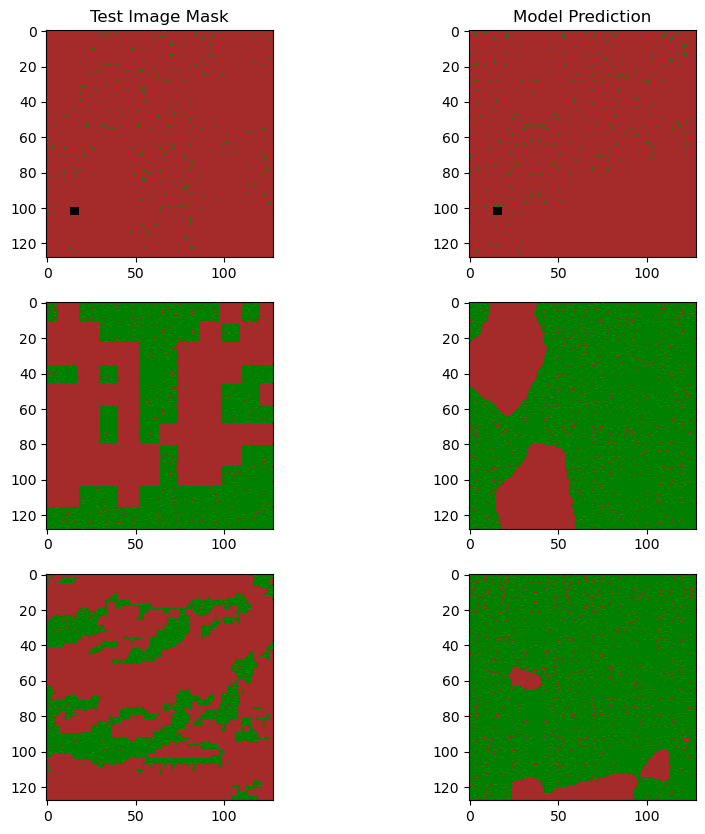

In [35]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        # Set predictions to 255 wherever the ignore class is present in the labels
        predicted[labels == 255] = 255

        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Flatten the tensors
all_preds_flat = all_preds.flatten()
all_labels_flat = all_labels.flatten()

# Mask to ignore the ignore_index
ignore_index = 255
mask = all_labels_flat != ignore_index

# Filter out the ignore_index
filtered_preds = all_preds_flat[mask]
filtered_labels = all_labels_flat[mask]

print("Accuracy:", accuracy_score(filtered_labels, filtered_preds))

precision = precision_score(filtered_labels, filtered_preds, average=None, zero_division=0)
recall = recall_score(filtered_labels, filtered_preds, average=None, zero_division=0)
f1 = f1_score(filtered_labels, filtered_preds, average=None, zero_division=0)

for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i} - Precision: {p}, Recall: {r}, F1 score: {f}")

# Define the colors for each specific value
colors = ['brown', 'green', 'black']

# Create a colormap
cmap = ListedColormap(colors)

# Define the boundaries for the values
boundaries = [0, 1, 2, 3]  # 0-1 -> black, 1-2 -> brown, 2-3 -> green

# Create a normalization
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Plot a test image mask and the model's prediction
idx = 7
rows = 3

fig, ax = plt.subplots(rows, 2, figsize=(10, 10))

ax[0][0].set_title("Test Image Mask")
ax[0][1].set_title("Model Prediction")
for i in range(rows):
    ax[i][0].imshow(all_labels[idx * rows + i], cmap=cmap, norm=norm)
    ax[i][1].imshow(all_preds[idx * rows + i], cmap=cmap, norm=norm)

plt.show()

In [ ]:
all_preds[idx]

In [ ]:
model_list = os.listdir('Model')

# Get the last number of the model
model_list = sorted(model_list, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Save the model with the next number

MODEL_SAVE_PATH = f"Model/model_{int(model_list[-1].split('_')[-1].split('.')[0]) + 1}.pth"

In [ ]:
# load model

model_num = 1

model = SegformerForSemanticSegmentation.from_pretrained(f"Model/model_{model_num}.pth")